# King County Home Sales

Let's begin by importing the packages we'll need. 

In [260]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Get and View Data

Next let's load our dataset from its CSV file into a Pandas dataframe. 

In [261]:
data = pd.read_csv('house_sales.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Describe the dataset. 

In [262]:
data.shape

(21613, 21)

There are 21,613 rows and 21 columns. Let's look at some descriptive statistics.

In [263]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,20479.000000,20545.000000,20503.000000,2.056900e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.372821,2.113507,2081.073697,1.517982e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930711,0.768913,915.043176,4.148617e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.500000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.070800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Let's look for any correlations between variables. 

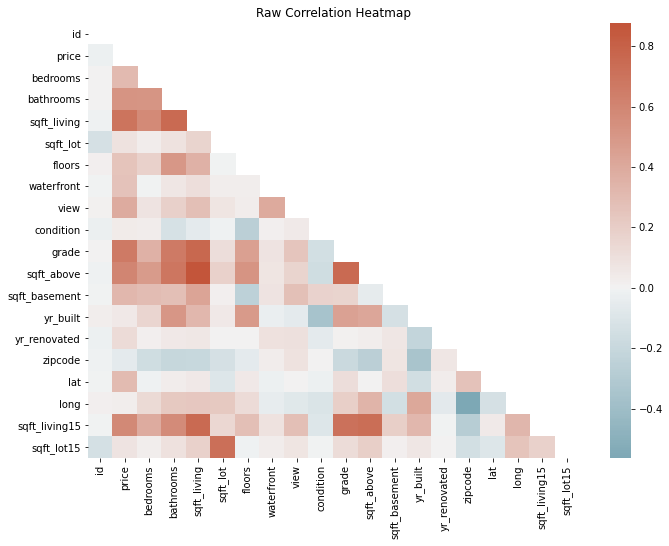

In [264]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(11, 8))
ax.set_title('Raw Correlation Heatmap')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(ax=ax, data=corr_matrix, mask=mask, cmap=cmap, center=0, annot=False)
plt.show()

We can see that bedrooms, bathrooms, sqft_living, grade, sqft_above, and sqft_living15 are the variables most strongly correlated with price, our dependent variable. 

Now let's check for any missing values in our dataset. 

In [265]:
data.isna().sum()

id                  0
date                0
price               0
bedrooms         1134
bathrooms        1068
sqft_living      1110
sqft_lot         1044
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated        0
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

bedrooms, bathrooms, sqft_living, and sqft_lot contain missing values. We'll deal with these later. 

Let's remove the columns that we will not use to model price. We decided to remove id and grade because id is unique to each home and grade is a score given to each home based on many of the variables already in the dataset. Even though grade was correlated with price, modeling price on grade would be not be very interesting or actionable, as grade is a blackbox representation of various home characteristics. 

In [266]:
data.drop(['id', 'grade'], axis=1, inplace=True)

## Handle Outliers

Let's start with the date column.

In [267]:
columns_with_outliers = set() 

In [268]:
type(data.date[0])

str

The values in the date column are strings. We should convert them to dates. 

In [269]:
data['date'] = pd.DatetimeIndex(data.date)

In [270]:
data.date.min(), data.date.max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

All of the dates are within 2014 and 2015, as expected. Let's move on to price. 

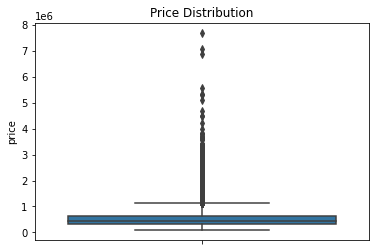

In [271]:
fig, ax = plt.subplots()
ax.set_title('Price Distribution')
sns.boxplot(data=data, y='price')
plt.show()

There are many price outliers that right-skew the distribution. Let's add it to our set of columns with outliers. And look at bedrooms. 

In [272]:
columns_with_outliers.add('price')

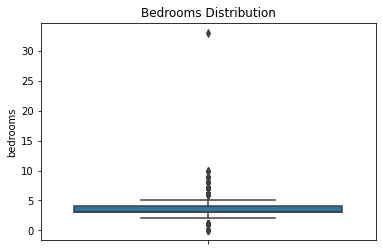

In [273]:
fig, ax = plt.subplots()
ax.set_title('Bedrooms Distribution')
sns.boxplot(data=data, y='bedrooms')
plt.show()

There are bedrooms outliers so let's add it to our set and look at bathrooms. 

In [274]:
columns_with_outliers.add('bedrooms')

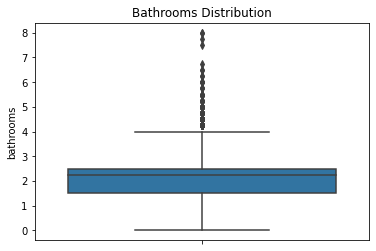

In [275]:
fig, ax = plt.subplots()
ax.set_title('Bathrooms Distribution')
sns.boxplot(data=data, y='bathrooms')
plt.show()

There are bathrooms outliers so let's add it to our set and look at sqft_living.

In [276]:
columns_with_outliers.add('bathrooms')

Let's now take a look at sqft_living. 

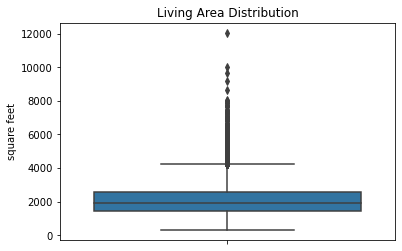

In [277]:
fig, ax = plt.subplots()
ax.set_title('Living Area Distribution')
sns.boxplot(data=data, y='sqft_living')
ax.set_ylabel('square feet')
plt.show()

There are sqft_living outliers so let's add it to our set and look at sqft_lot. 

In [278]:
columns_with_outliers.add('sqft_living')

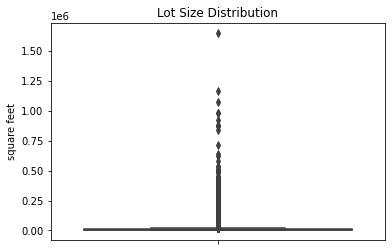

In [279]:
fig, ax = plt.subplots()
ax.set_title('Lot Size Distribution')
sns.boxplot(data=data, y='sqft_lot')
ax.set_ylabel('square feet')
plt.show()

This distribution is extremely right-skewed with many outliers. Let's add it to our set and look at floors.

In [280]:
columns_with_outliers.add('sqft_lot')

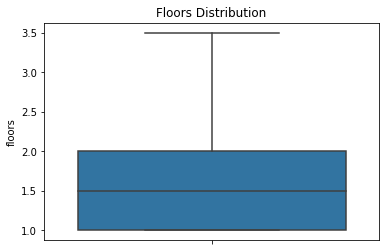

In [281]:
fig, ax = plt.subplots()
ax.set_title('Floors Distribution')
sns.boxplot(data=data, y='floors')
plt.show()

There are no floors outliers so let's move on. waterfront is a binary variable with a max of 1 so no outliers there. view is supposed to be a binary variable but the max is 4, so it must have some data errors. 

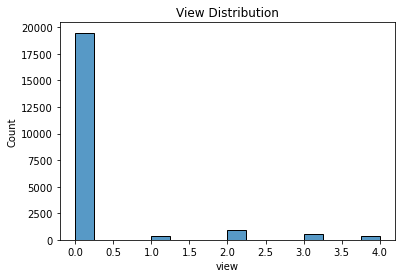

In [282]:
fig, ax = plt.subplots()
ax.set_title('View Distribution')
sns.histplot(data.view)
plt.show()

Some view values are 2, 3, and 4. Let's add this to our set but make sure we treat it differently when it comes time to actually identify outliers. 

In [283]:
columns_with_outliers.add('view')

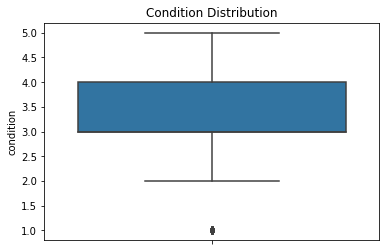

In [284]:
fig, ax = plt.subplots()
ax.set_title('Condition Distribution')
sns.boxplot(data=data, y='condition')
plt.show()

Condition has outliers so let's add it to our set and look at sqft_above.

In [285]:
columns_with_outliers.add('condition')

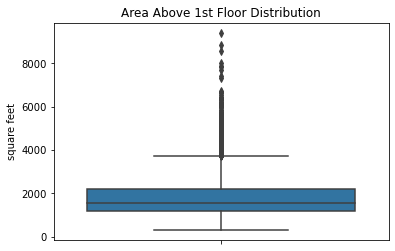

In [286]:
fig, ax = plt.subplots()
ax.set_title('Area Above 1st Floor Distribution')
sns.boxplot(data=data, y='sqft_above')
ax.set_ylabel('square feet')
plt.show()

sqft_above has outliers so let's add it to our set and look at sqft_basement.

In [287]:
columns_with_outliers.add('sqft_above')

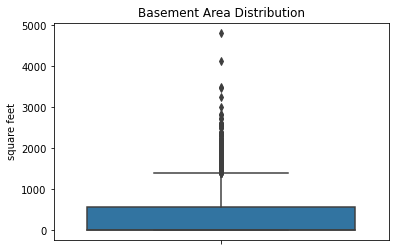

In [288]:
fig, ax = plt.subplots()
ax.set_title('Basement Area Distribution')
sns.boxplot(data=data, y='sqft_basement')
ax.set_ylabel('square feet')
plt.show()

sqft_basement has outliers so let's add it to our set and look at yr_built.

In [289]:
columns_with_outliers.add('sqft_basement')

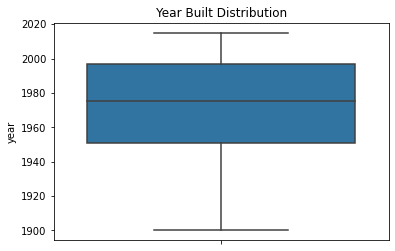

In [290]:
fig, ax = plt.subplots()
ax.set_title('Year Built Distribution')
sns.boxplot(data=data, y='yr_built')
ax.set_ylabel('year')
plt.show()

No yr_built outliers. Let's look at yr_renovated. Homes that have not been renovated have a value of 0. Let's replace these with nulls so they don't skew the distribution. 

In [291]:
data.yr_renovated.replace(0, np.nan, inplace=True)

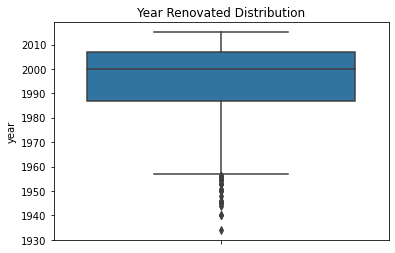

In [292]:
fig, ax = plt.subplots()
ax.set_title('Year Renovated Distribution')
sns.boxplot(data=data, y='yr_renovated')
ax.set_ylabel('year')
plt.show()

There are some outliers so let's add this to our set and look at zipcode. 

In [293]:
columns_with_outliers.add('yr_renovated')

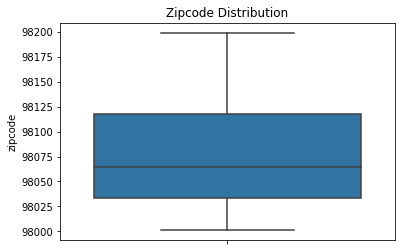

In [294]:
fig, ax = plt.subplots()
ax.set_title('Zipcode Distribution')
sns.boxplot(data=data, y='zipcode')
plt.show()

No zipcode outliers so let's move on to sqft_living15. 

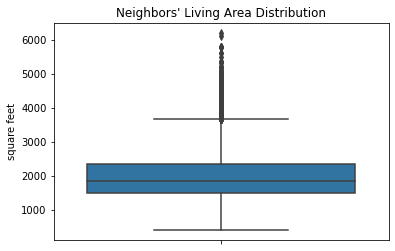

In [295]:
fig, ax = plt.subplots()
ax.set_title("Neighbors' Living Area Distribution")
sns.boxplot(data=data, y='sqft_living15')
ax.set_ylabel('square feet')
plt.show()

It has outliers so let's add it to our set and look at sqft_lot15. 

In [296]:
columns_with_outliers.add('sqft_living15')

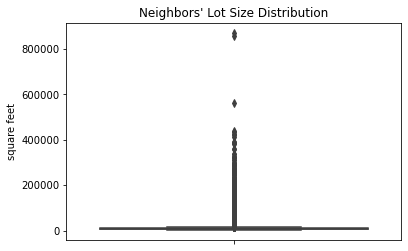

In [297]:
fig, ax = plt.subplots()
ax.set_title("Neighbors' Lot Size Distribution")
sns.boxplot(data=data, y='sqft_lot15')
ax.set_ylabel('square feet')
plt.show()

There are some very extreme outliers so let's add this column to our set as well. 

In [298]:
columns_with_outliers.add('sqft_lot15')

In [299]:
columns_with_outliers

{'bathrooms',
 'bedrooms',
 'condition',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'yr_renovated'}

Now that we've identified all the columns with outliers, let's define some functions to identify and consolidate their outliers. The first function get_outliers() returns a dataframe with all of the rows containing the given column's outliers. The second function consolidate_outliers() runs get_outliers() on each column and consolidates the resulting dataframes into a single dataframe that contains all rows containing outliers from any of the columns.  

In [300]:
def get_outliers(column):
    if column == 'view': # special logic to handle the view column 
        return data[data.view > 1]
    q1 = data[column].quantile(.25) 
    q3 = data[column].quantile(.75)
    iqr = q3 - q1
    return data[(data[column] < q1 - 1.5 * iqr) | (data[column] > q3 + 1.5 * iqr)]

In [301]:
def consolidate_outliers(columns): 
    outlier_dfs = [] # list to store the dataframes with each column's outliers 
    for c in columns: # for each column 
        df = get_outliers(c) # get its outliers as a dataframe
        outlier_dfs.append(df) # add that dataframe to the list 
    return pd.concat(outlier_dfs).drop_duplicates() # vertically combine the dataframes and drop duplicate rows

In [302]:
outliers = consolidate_outliers(columns_with_outliers)
outliers.shape

(5242, 19)

Our consolidated, deduped dataframe of outliers from all columns has 5,242 home sales. Let's remove them from our dataset. 

In [303]:
data = data.merge(
    outliers,
    how='outer',
    indicator=True
).query('_merge == "left_only"').drop('_merge', axis=1)
data.shape

(16371, 19)

We have 16,371 rows left after removing the outliers. 
We decided to be strict with our outlier criteria because our goal was to create a general model of home price, not one that is skewed by outliers like mansions or farmsteads.
Let's take another look at the correlation heatmap to see if it changed after removing outliers. 

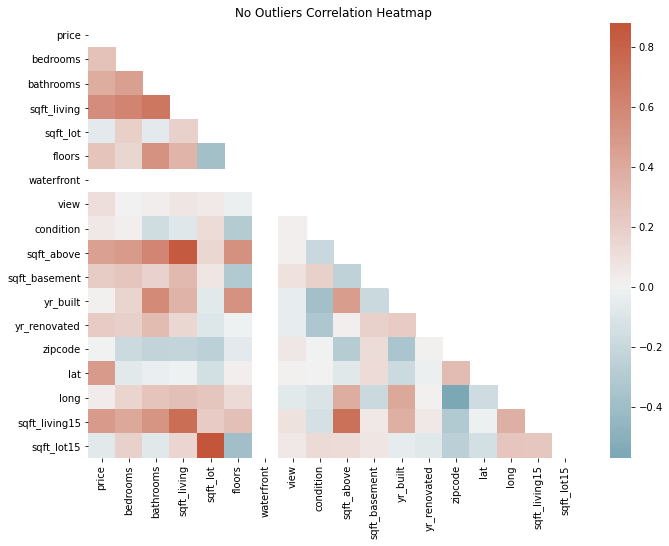

In [304]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(11, 8))
ax.set_title('No Outliers Correlation Heatmap')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(ax=ax, data=corr_matrix, mask=mask, cmap=cmap, center=0, annot=False)
plt.show()

Removing outliers removed all waterfront homes from the dataset. It also strengthened the positive correlation between sqft_lot and sqft_lot15. 

## Impute Missing Data

In [305]:
data.isna().sum()

date                 0
price                0
bedrooms           879
bathrooms          774
sqft_living        845
sqft_lot           850
floors               0
waterfront           0
view                 0
condition            0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated     15861
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

bedrooms, bathrooms, sqft_living, sqft_lot, and yr_renovated have missing values. yr_renovated only has missing values because we replaced the 0's with nulls when looking for outliers. Let's change them back to 0's. 

In [306]:
data.yr_renovated.fillna(0, inplace=True)
data.yr_renovated.isna().sum()

0

We saw from the correlation matrix that sqft_lot and sqft_lot15 are strongly positively correlated, as are sqft_living and sqft_living15. Let's leverage this relationship to predict the missing sqft_lot and sqft_living values based on sqft_lot15 and sqft_living15, respectively.

In [307]:
data.sqft_lot.corr(data.sqft_lot15)

0.8791175047808103

In [308]:
data.sqft_living.corr(data.sqft_living15)

0.7345898196196478

Let's create a dataframe of rows with null sqft_living and sqft_lot to use later.

In [309]:
nullsqft_living = data['sqft_living'].isnull()
null_living = pd.DataFrame(data['sqft_living15'][nullsqft_living])

nullsqft_lot = data['sqft_lot'].isnull()
null_lot = pd.DataFrame(data['sqft_lot15'][nullsqft_lot])

Next we'll create a dataset where sqft_living and sqft_lot are non-empty and use this to train the regression imputation model. 

In [310]:
filtereddata = data.dropna(subset = ['sqft_living', 'sqft_lot'])
filtereddata.shape[0]

14717

Let's start by linearly regressing sqft_lot on sqft_lot15. 

In [311]:
model = ols("sqft_lot ~ sqft_lot15", data=filtereddata).fit()
modelsummary = model.summary()
print(modelsummary)

                            OLS Regression Results                            
Dep. Variable:               sqft_lot   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 4.981e+04
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:04:57   Log-Likelihood:            -1.2962e+05
No. Observations:               14717   AIC:                         2.592e+05
Df Residuals:                   14715   BIC:                         2.593e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    202.8950     33.551      6.047      0.0

We can use the fitted linear regression to predict the missing sqft_lot values. 

In [312]:
data['sqft_lot_pred'] = model.predict(data.sqft_lot15) # use the model to predict sqft_lot from sqft_lot15

In [313]:
data['sqft_lot'] = data.apply(
    lambda row:
        row.sqft_lot_pred
    if np.isnan(row.sqft_lot) else row.sqft_lot, axis=1)
data.drop(columns=['sqft_lot_pred'], inplace=True) # we no longer need this column now that we've imputed sqft_lot

Let's take a look at the post-imputation relationship between sqft_lot and sqft_lot15.

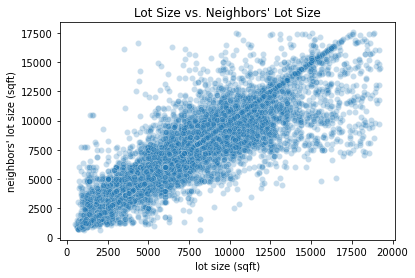

0.884887228449984

In [314]:
fig, ax = plt.subplots()
ax.set_title("Lot Size vs. Neighbors' Lot Size")
sns.scatterplot(data=data, x='sqft_lot', y='sqft_lot15', alpha=0.25)
ax.set_xlabel('lot size (sqft)')
ax.set_ylabel("neighbors' lot size (sqft)")
plt.show()
data.sqft_lot.corr(data.sqft_lot15)

We can see the regression line formed by the imputed values, and the variables' correlation coefficient increased. 

Now let's do the same process but with sqft_living and sqft_living15.

In [315]:
model = ols("sqft_living ~ sqft_living15", data=filtereddata).fit()
modelsummary = model.summary()
print(modelsummary)

                            OLS Regression Results                            
Dep. Variable:            sqft_living   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 1.707e+04
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:04:58   Log-Likelihood:            -1.1045e+05
No. Observations:               14717   AIC:                         2.209e+05
Df Residuals:                   14715   BIC:                         2.209e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       229.0443     12.866     17.802

In [316]:
data['sqft_living_pred'] = model.predict(data.sqft_living15) # use the model to predict sqft_living from sqft_living15

In [317]:
data['sqft_living'] = data.apply(
    lambda row:
        row.sqft_living_pred
    if np.isnan(row.sqft_living) else row.sqft_living, axis=1)
data.drop(columns=['sqft_living_pred'], inplace=True) # we no longer need this column now that we've imputed sqft_living

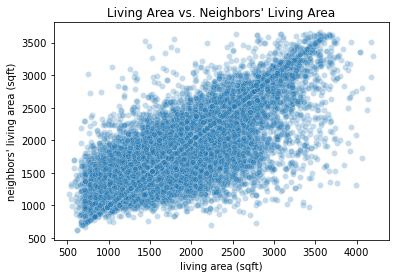

0.7431137994860139

In [318]:
fig, ax = plt.subplots()
ax.set_title("Living Area vs. Neighbors' Living Area")
sns.scatterplot(data=data, x='sqft_living', y='sqft_living15', alpha=0.25)
ax.set_xlabel('living area (sqft)')
ax.set_ylabel("neighbors' living area (sqft)")
plt.show()
data.sqft_living.corr(data.sqft_living15)

In [319]:
data.isna().sum()

date               0
price              0
bedrooms         879
bathrooms        774
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
sqft_living15      0
sqft_lot15         0
dtype: int64

As expected, there are no longer any missing sqft_living or sqft_lot values. 

Now let's work on imputing bedrooms and bathrooms. 

We'll start by creating a dataset without any missing values for bedrooms and bathrooms.

In [320]:
filtereddata2 = data.dropna(subset = ['bedrooms', 'bathrooms'])
filtereddata2.shape[0]

14765

In [321]:
filtereddata2.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.476500e+04,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.0,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000,14765.000000
mean,4.485061e+05,3.269556,1.987690,1843.836759,7091.536021,1.473789,0.0,0.013884,3.409482,1611.939045,231.678767,1970.676194,63.587335,98080.140400,47.558716,-122.226000,1816.674771,6969.034812
std,1.902914e+05,0.779077,0.661877,638.400862,3376.831450,0.541702,0.0,0.117014,0.642479,632.474746,356.768538,29.736756,350.703983,53.425657,0.139876,0.132303,532.906210,3021.583538
min,8.200000e+04,2.000000,0.500000,520.000000,520.000000,1.000000,0.0,0.000000,2.000000,480.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.472000,620.000000,659.000000
25%,3.013500e+05,3.000000,1.500000,1370.000000,4788.000000,1.000000,0.0,0.000000,3.000000,1140.000000,0.000000,1951.000000,0.000000,98033.000000,47.464600,-122.334000,1430.000000,4871.000000
50%,4.150000e+05,3.000000,2.000000,1760.000000,7111.000000,1.000000,0.0,0.000000,3.000000,1450.000000,0.000000,1973.000000,0.000000,98072.000000,47.568600,-122.261000,1714.000000,7200.000000
75%,5.600000e+05,4.000000,2.500000,2240.000000,9001.000000,2.000000,0.0,0.000000,4.000000,1950.000000,450.000000,1998.000000,0.000000,98118.000000,47.681300,-122.149000,2120.000000,8770.000000
max,1.127000e+06,5.000000,4.000000,4200.000000,19210.000000,3.500000,0.0,1.000000,5.000000,3740.000000,1400.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.319000,3660.000000,17550.000000


In [322]:
filtereddata2.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.264865,0.390239,0.556092,-0.061737,0.263282,NaN,0.102514,0.046400,0.458317,0.201706,0.012478,0.094108,0.000665,0.481087,0.032513,0.487261,-0.068176
bedrooms,0.264865,1.000000,0.463805,0.605727,0.194640,0.156451,NaN,0.005751,0.011267,0.490833,0.241758,0.174712,0.011291,-0.179570,-0.069668,0.170787,0.411566,0.183176
bathrooms,0.390239,0.463805,1.000000,0.678946,-0.066379,0.530414,NaN,0.022759,-0.163632,0.607657,0.168991,0.576047,0.019696,-0.227157,-0.032935,0.259178,0.522404,-0.070660
sqft_living,0.556092,0.605727,0.678946,1.000000,0.181743,0.349934,NaN,0.066160,-0.089267,0.838240,0.304535,0.357136,0.021154,-0.219731,-0.005204,0.279716,0.744108,0.169699
sqft_lot,-0.061737,0.194640,-0.066379,0.181743,1.000000,-0.371441,NaN,0.037470,0.124798,0.145376,0.066975,-0.069373,-0.009061,-0.253811,-0.138734,0.243933,0.220659,0.884326
floors,0.263282,0.156451,0.530414,0.349934,-0.371441,1.000000,NaN,-0.027384,-0.289885,0.539747,-0.314718,0.531614,-0.010480,-0.069132,0.017700,0.141433,0.283987,-0.379367
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,0.102514,0.005751,0.022759,0.066160,0.037470,-0.027384,NaN,1.000000,0.013565,0.011407,0.096725,-0.042233,0.021309,0.061174,0.009343,-0.066366,0.086626,0.047444
condition,0.046400,0.011267,-0.163632,-0.089267,0.124798,-0.289885,NaN,0.013565,1.000000,-0.194961,0.184078,-0.382339,-0.062457,0.000279,0.004276,-0.103765,-0.142411,0.127492
sqft_above,0.458317,0.490833,0.607657,0.838240,0.145376,0.539747,NaN,0.011407,-0.194961,1.000000,-0.240984,0.472146,-0.008816,-0.291072,-0.076793,0.390702,0.722430,0.134378


Bathrooms and bedrooms do not have a strong correlation with any of the other variables so we will use median imputation. We chose median instead of mean because the latter would introduce nonsensical values like 3.27 bedrooms and 1.99 bathrooms into our dataset. 

In [323]:
data.median(numeric_only=True)

price            415000.0000
bedrooms              3.0000
bathrooms             2.0000
sqft_living        1760.0000
sqft_lot           7100.0000
floors                1.0000
waterfront            0.0000
view                  0.0000
condition             3.0000
sqft_above         1440.0000
sqft_basement         0.0000
yr_built           1973.0000
yr_renovated          0.0000
zipcode           98072.0000
lat                  47.5693
long               -122.2620
sqft_living15      1714.0000
sqft_lot15         7200.0000
dtype: float64

In [324]:
data['bedrooms'] = data['bedrooms'].fillna(data['bedrooms'].median())

In [325]:
data['bathrooms'] = data['bathrooms'].fillna(data['bathrooms'].median())

In [326]:
data.median(numeric_only=True)

price            415000.0000
bedrooms              3.0000
bathrooms             2.0000
sqft_living        1760.0000
sqft_lot           7100.0000
floors                1.0000
waterfront            0.0000
view                  0.0000
condition             3.0000
sqft_above         1440.0000
sqft_basement         0.0000
yr_built           1973.0000
yr_renovated          0.0000
zipcode           98072.0000
lat                  47.5693
long               -122.2620
sqft_living15      1714.0000
sqft_lot15         7200.0000
dtype: float64

Median bedrooms and bathrooms did not change so our imputation did not dramatically skew their distributions. 

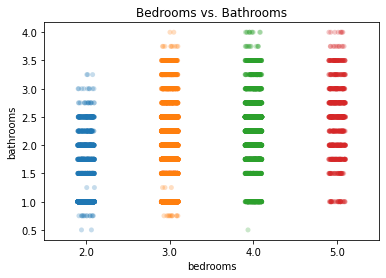

In [327]:
fig, ax = plt.subplots()
ax.set_title('Bedrooms vs. Bathrooms')
sns.stripplot(data=data, x='bedrooms', y='bathrooms', alpha=0.25)
plt.show()

In [328]:
data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

As expected, our dataset no longer has any missing values after imputation. Let's take another look at our correlation heatmap now that we have a clean dataset. 

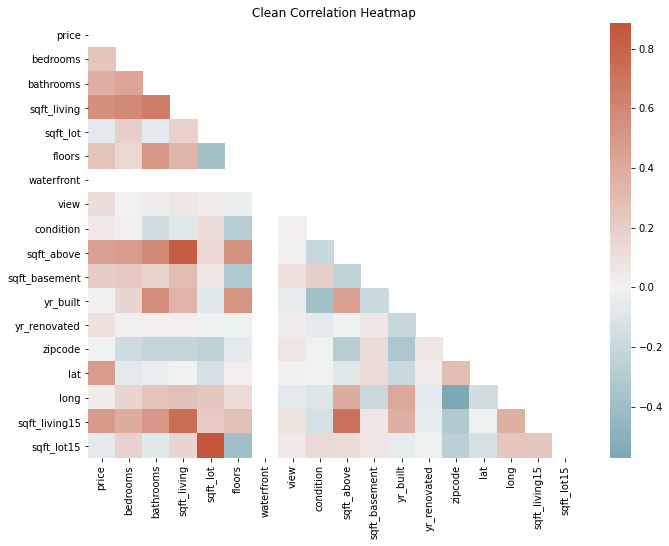

In [329]:
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize=(11, 8))
ax.set_title('Clean Correlation Heatmap')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(ax=ax, data=corr_matrix, mask=mask, cmap=cmap, center=0, annot=False)
plt.show()

## Engineer Features

### Location

zipcode is a categorical variable with 70 unique values. We'll need to dummify it if we're going to include it in our model. But 69 binary variables is a lot, so first we should check whether zipcode is at all informative of price. 

<ipython-input-330-5d72db006025>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


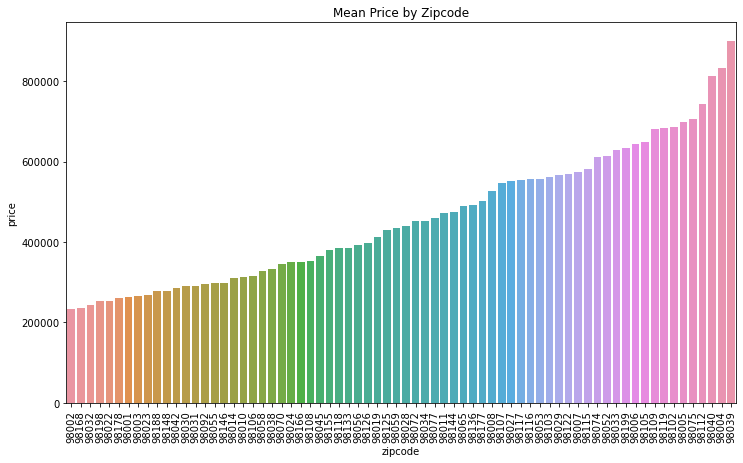

In [330]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title('Mean Price by Zipcode')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
mean_price_by_zipcode = data.groupby(['zipcode'])[['price']].mean().reset_index()
sns.barplot(
    data=mean_price_by_zipcode, 
    x='zipcode', 
    y='price', 
    order=mean_price_by_zipcode.sort_values('price').zipcode
)
plt.show()

It looks like there's quite a lot of variance in price across zipcodes, so zipcode could be helpful in predicting a home's sell price. 

Let's try clustering homes on latitude and longitude to see if we can capture location information with fewer categories. Let's start by plotting lat and long and coloring by price. 

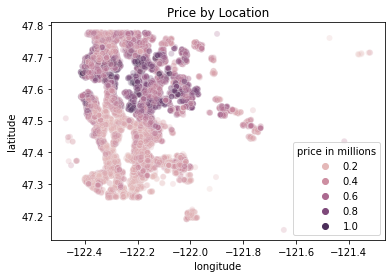

In [331]:
fig, ax = plt.subplots()
ax.set_title('Price by Location')
sns.scatterplot(data=data, x='long', y='lat', hue='price', alpha=0.25)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.legend(title='price in millions')
plt.show()

It looks like price does vary by geographic region. Let's try clustering on geo coordinates using the K Means algorithm. 

We don't know which number of clusters is optimal so we'll have to iteratively test out different values. 

In [332]:
coords = data[['long', 'lat']].values # store lat and long as a numpy array
k_clusters = np.arange(2, 21) # we'll be testing 2 to 20 clusters 
sse_scores = [] 
silhouette_scores = []
for k in k_clusters: # for each number of clusters 
    kmeans = cluster.KMeans(n_clusters=k, random_state=5) # instantiate a K Means with that many clusters
    kmeans.fit(coords) # fit it to the coordinates 
    sse_scores.append(kmeans.inertia_) # record its Sum of Squared Errors 
    silhouette_scores.append(silhouette_score(coords, kmeans.labels_)) # record its Silhouette Score 

In [333]:
# store the scores for each k calculated above in a dataframe for easy plotting 
kmeans_scores = pd.DataFrame({
    'k': k_clusters,
    'SSE': sse_scores,
    'Silhouette Coefficient': silhouette_scores
})

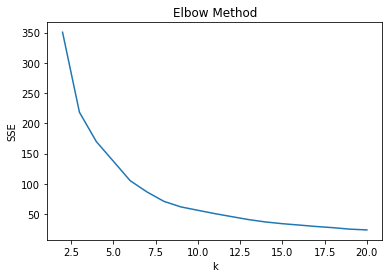

In [334]:
fig, ax = plt.subplots()
ax.set_title('Elbow Method')
sns.lineplot(data=kmeans_scores, x='k', y='SSE')
plt.show()

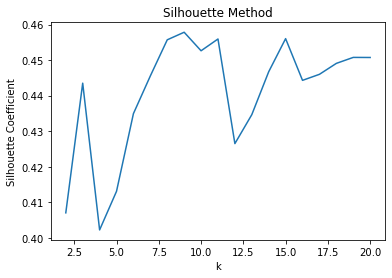

In [335]:
fig, ax = plt.subplots()
ax.set_title('Silhouette Method')
sns.lineplot(data=kmeans_scores, x='k', y='Silhouette Coefficient')
plt.show()

Using the Elbow Method we can see that the SSE curve's inflection is around k=8. We also see that the Silhouette Coefficient's maximum occurs at around k=8. These metrics' corroboration gives us confidence to move forward with 8 clusters. 

In [336]:
kmeans = cluster.KMeans(n_clusters=8, random_state=5).fit(coords)
data['cluster'] = kmeans.labels_ # store the homes' cluster labels as a column in our dataset 

Let's plot our geo clusters and see how they look. 

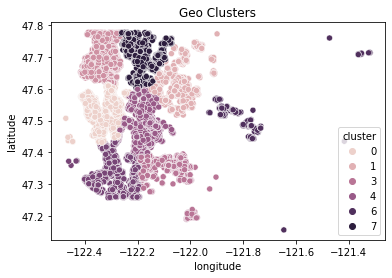

In [337]:
fig, ax = plt.subplots()
ax.set_title('Geo Clusters')
sns.scatterplot(data=data, x='long', y='lat', hue='cluster')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

Looks pretty good! But do they correlate with price? Let's start by giving them more intuitive names.

In [338]:
cluster_names = {
    0: 'west_central',
    1: 'northeast',
    2: 'northwest',
    3: 'southeast',
    4: 'east_central',
    5: 'southwest',
    6: 'inland',
    7: 'north_central'
}
data.cluster.replace(cluster_names, inplace=True)

Let's also map them to a palette so their colors will be consistent across visualizations.

In [339]:
cluster_colors = {cluster: color for cluster, color in zip(data.cluster.unique(), sns.color_palette())}

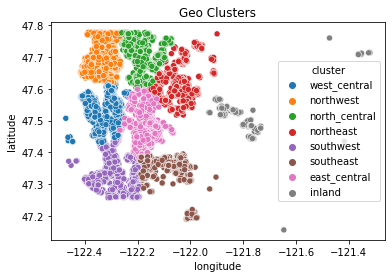

In [340]:
fig, ax = plt.subplots()
ax.set_title('Geo Clusters')
sns.scatterplot(data=data, x='long', y='lat', hue='cluster', palette=cluster_colors)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [341]:
mean_price_by_cluster = data.groupby('cluster').price.mean().sort_values()
mean_price_by_cluster

cluster
southwest        266324.635995
southeast        299937.237854
west_central     395253.689116
east_central     427298.096555
inland           431628.953247
northwest        533411.622538
north_central    542247.935244
northeast        570197.374320
Name: price, dtype: float64

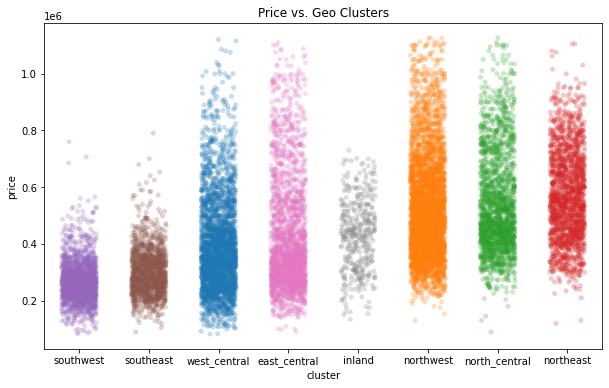

In [342]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Price vs. Geo Clusters')
sns.stripplot(
    data=data, 
    x='cluster', 
    y='price', 
    palette=cluster_colors,
    order=mean_price_by_cluster.index,
    alpha=0.25,
    jitter=0.25
)
plt.show()

In [343]:
cluster_dummies = pd.get_dummies(data.cluster)
cluster_dummies.drop(columns=['west_central'], inplace=True)
cluster_dummies.head()

,east_central,inland,north_central,northeast,northwest,southeast,southwest
0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0


In [344]:
exog = sm.add_constant(cluster_dummies)
endog = data.price
lm = sm.OLS(endog, exog).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.284
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     927.7
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:07:12   Log-Likelihood:            -2.1958e+05
No. Observations:               16371   AIC:                         4.392e+05
Df Residuals:                   16363   BIC:                         4.392e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.953e+05   2983.190    132.494

Our geo clusters alone explain 28.4% of variance in home price. Not bad! Let's add them to the rest of our data and drop the columns used to derive them. 

In [345]:
data = pd.concat([data, cluster_dummies], axis=1)
data.drop(columns=['zipcode', 'lat', 'long', 'cluster'], inplace=True)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,sqft_living15,sqft_lot15,east_central,inland,north_central,northeast,northwest,southeast,southwest
0,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,...,0.0,1340,5650,0,0,0,0,0,0,0
1,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,...,1991.0,1690,7639,0,0,0,0,1,0,0
2,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,...,0.0,2720,8062,0,0,1,0,0,0,0
3,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,...,0.0,1360,5000,0,0,0,0,0,0,0
4,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,...,0.0,1800,7503,0,0,0,1,0,0,0


### Age

We should express yr_built as an age to make it more interpretable. 

In [346]:
data['age'] = data.date.dt.year - data.yr_built
data.age.describe()

count    16371.000000
mean        43.579134
std         29.766278
min         -1.000000
25%         16.000000
50%         41.000000
75%         64.000000
max        115.000000
Name: age, dtype: float64

It looks like there are some houses with an inferred age of -1. Let's inspect them.

In [347]:
data[data.age == -1][['date', 'yr_built']]

,date,yr_built
1763,2014-06-25,2015
7526,2014-12-31,2015
8039,2014-06-24,2015
14489,2014-08-26,2015
17098,2014-06-17,2015
19805,2014-08-01,2015
20852,2014-07-09,2015
20963,2014-07-31,2015
21262,2014-11-25,2015


It looks like these are likely just data entry errors. Let's change their age to 0. 

In [348]:
data.age.replace(-1, 0, inplace=True)
data.age.describe()

count    16371.000000
mean        43.579684
std         29.765464
min          0.000000
25%         16.000000
50%         41.000000
75%         64.000000
max        115.000000
Name: age, dtype: float64

Let's now transform yr_renovated into a binary variable that indicates whether or not a house has been renovated. 

In [349]:
data['was_renovated'] = data.apply(
    lambda row: 1 if row.yr_renovated != 0 else 0,
    axis=1
)
data.was_renovated

0        0
1        1
2        0
3        0
4        0
        ..
21608    0
21609    0
21610    0
21611    0
21612    0
Name: was_renovated, Length: 16371, dtype: int64

Let's drop yr_built and yr_renvated since we've replaced them with their transformed versions. 

In [350]:
data.drop(columns=['yr_built', 'yr_renovated'], inplace=True)
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'east_central',
       'inland', 'north_central', 'northeast', 'northwest', 'southeast',
       'southwest', 'age', 'was_renovated'],
      dtype='object')

### Season

We should capture the housing market's seasonality, so let's derive a categorical season variable from date. 

In [351]:
def get_season(date):
    if date.month in (12, 1, 2):
        return 'winter'
    if date.month in (3, 4, 5): 
        return 'spring'
    if date.month in (6, 7, 8):
        return 'summer'
    if date.month in (9, 10, 11):
        return 'fall'

In [352]:
data['season'] = data.apply(lambda row: get_season(row.date), axis=1)
data['season'].describe()

count      16371
unique         4
top       spring
freq        4910
Name: season, dtype: object

In [353]:
season_dummies = pd.get_dummies(data.season, drop_first=True)
season_dummies.describe()

,spring,summer,winter
count,16371.000000,16371.000000,16371.000000
mean,0.299921,0.293201,0.172500
std,0.458237,0.455244,0.377826
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [354]:
data = pd.concat([data, season_dummies], axis = 1)
data.drop(columns=['date', 'season'], inplace=True)
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'east_central', 'inland',
       'north_central', 'northeast', 'northwest', 'southeast', 'southwest',
       'age', 'was_renovated', 'spring', 'summer', 'winter'],
      dtype='object')

## Predicting Price

Now that we have a clean and enriched dataset, let's use it to model home sale price.
Let's start with a linear regression on all independent variables. 

### Linear Regression 

In [355]:
X = data.drop('price', axis=1) 
Y = data['price']
X  = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1309.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:07:14   Log-Likelihood:            -2.1376e+05
No. Observations:               16371   AIC:                         4.276e+05
Df Residuals:                   16347   BIC:                         4.278e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.153e+05   8579.553    -13.441

Let's check for multicollinearity. 

In [356]:
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

C:\Users\aabel\Anaconda3\envs\ADS500B\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0           const  93.619281
1        bedrooms   1.633625
2       bathrooms   2.728749
3     sqft_living  41.009021
4        sqft_lot   4.823450
5          floors   2.712507
6      waterfront        NaN
7            view   1.032229
8       condition   1.292754
9      sqft_above  39.990151
10  sqft_basement  13.316889
11  sqft_living15   2.726343
12     sqft_lot15   4.911113
13   east_central   1.913086
14         inland   1.208257
15  north_central   1.806211
16      northeast   1.888688
17      northwest   1.830428
18      southeast   1.658357
19      southwest   1.673578
20            age   2.639953
21  was_renovated   1.117826
22         spring   1.599228
23         summer   1.596402
24         winter   1.440694


Let's remove sqft_above, bedrooms, sqft_basement because of their high VIF's. Let's also remove sqft_living15 and sqft_lot15 since we leveraged their multicollinearity to impute sqft_living and sqft_lot. Let's also remove winter because of its high p-value. 

In [357]:
X2 = data.drop(['price', 'sqft_above', 'bedrooms', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'winter'], axis=1) 
Y = data['price']
X2  = sm.add_constant(X2)
model = sm.OLS(Y, X2).fit()
predictions = model.predict(X2) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1552.
Date:                Sun, 18 Apr 2021   Prob (F-statistic):               0.00
Time:                        11:07:15   Log-Likelihood:            -2.1445e+05
No. Observations:               16371   AIC:                         4.289e+05
Df Residuals:                   16353   BIC:                         4.291e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -8.821e+04   8093.789    -10.899

Let's see if these changes addressed the multicollinearity problems. 

In [358]:
vif = pd.DataFrame()
vif["variables"] = X2.columns
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
print(vif)

C:\Users\aabel\Anaconda3\envs\ADS500B\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0           const  76.641659
1       bathrooms   2.514603
2     sqft_living   2.060050
3        sqft_lot   1.596062
4          floors   1.977565
5      waterfront        NaN
6            view   1.017324
7       condition   1.269387
8    east_central   1.803567
9          inland   1.178888
10  north_central   1.718673
11      northeast   1.753814
12      northwest   1.816259
13      southeast   1.577286
14      southwest   1.626134
15            age   2.607017
16  was_renovated   1.111625
17         spring   1.218141
18         summer   1.221183


Removing 'sqft_above', 'bedrooms', 'sqft_basement', 'sqft_living15', 'sqft_lot15', and 'winter' seems to have improved the VIF's. Let's interpret the results of our final model. It explains 61.7% of the variance in price and tells us that on average: 
- Each additional bathroom is associated with an additional 21,790 dollars. 
- Each additional square foot of living area is associated with an additional 160 dollars. 
- Each additional sqare foot of lot area is associated with a decrease of 3.58 dollars. 
- Each additional floor is associated with an additional 35,040 dollars . 
- Waterfront is a constant because we removed all waterfront homes when we removed the outliers. It's coefficient is so small it is practically zero. 
- Homes with a view sell for 103,500 dollars more.  
- Each additional condition point is associated with an additional 26,500 dollars. 
- Homes in the East Central region sell for 13,320 dollars less than those in the West Central region. 
- Homes in the Inland region sell for 14,940 dollars less than those in the West Central region. 
- Homes in the North Central region sell for 105,700 dollars more than those in the West Central region. 
- Homes in the North East region sell for 105,900 dollars more than those in the West Central region. 
- Homes in the North West region sell for 115,700 dollars more than those in the West Central region. 
- Homes in the South East region sell for 117,700 dollars less than those in the West Central region. 
- Homes in the South West region sell for 131,300 dollars less than those in the West Central region. 
- Each additional year of a home's age is associated with an additional 1,028 dollars. 
- Homes that have been renovated sell for 44,290 dollars more. 
- Homes sold in the spring months sell for 21,890 dollars more than those sold during the fall months. 
- Homes sold in the summer months sell for 4,943 dollars more than those sold during the fall months. 

Below are a couple other models we explored, but ultimately decided not to go with. 

### K Nearest Neighbors 

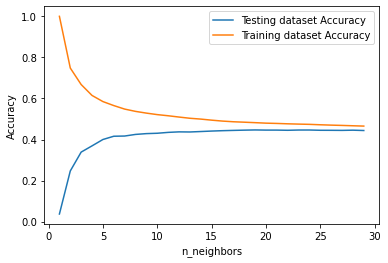

In [359]:
x = data.drop(['price', 'price'],axis=1) 
y = data['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

neighbors = np.arange(1, 30)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(x_train, y_train)
      
    # Compute traning and test data accuracy
    train_accuracy[i] = knn.score(x_train, y_train)
    test_accuracy[i] = knn.score(x_test, y_test)
  
# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()  

I will use 20 neighbors because that appears to give the highest accuracy for both training and test datasets.

In [360]:
knn_model = KNeighborsRegressor(n_neighbors=20)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print("KNN Test set predictions: {}".format(knn_model.predict(x_test)))
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", knn_model.score(x_test, y_test))

KNN Test set predictions: [366665.  643485.  456212.5 ... 528171.5 292123.  685796.5]
Accuracy: 0.4457882221270256


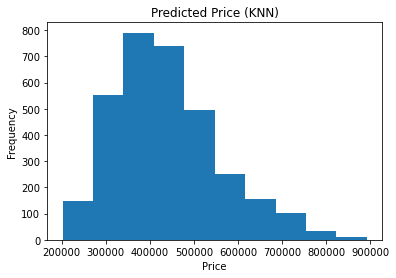

In [361]:
knn_pred = knn_model.predict(x_test)
plt.hist(knn_pred) 
plt.title("Predicted Price (KNN)") 
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

### Ridge Regression 

In [362]:
x = data.drop(['price', 'sqft_above'],axis=1) 
y = data['price']

#array of possible alpha values for CV later
alphas = 10**np.linspace(10,-2,100)*0.5

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

ridge = Ridge(alpha=.05, normalize = True)
ridge.fit(x_train, y_train)
pred_ridge = ridge.predict(x_test)

print("Ridge Training set score: {:.2f}".format(ridge.score(x_train, y_train)))
print("Ridge Test set score: {:.2f}".format(ridge.score(x_test, y_test)))
print("R^2:", r2_score(y_test, pred_ridge))
print("MSE:", mean_squared_error(y_test, pred_ridge))

Ridge Training set score: 0.64
Ridge Test set score: 0.66
R^2: 0.6575378006352501
MSE: 12782534674.149183


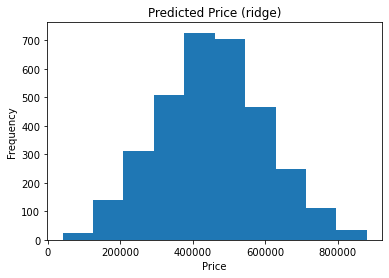

In [363]:
plt.hist(pred_ridge) 
plt.title("Predicted Price (ridge)") 
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()